In [0]:
%tensorflow_version 2.x

In [25]:
from zipfile import ZipFile
file_name = 'dataset_.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [26]:
from imutils import paths
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix


import numpy as np
import cv2
import os

imagePaths = list(paths.list_images('/content/dataset_'))

data = []
labels = []
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	data.append(image)
	labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = tensorflow.keras.utils.to_categorical(labels)

# experimented with test size due to lack of data. Settled on .25.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = .25, stratify=labels, random_state=42)

# image augmentation for training
train_aug = ImageDataGenerator(rotation_range=15, fill_mode='nearest')


input_shape = (224, 224, 3)
# Base model is pretrained on imagenet
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(64, activation='elu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

# head_model placed on top of vgg16
model = Model(inputs=base_model.input, outputs=head_model)
for layer in base_model.layers:
  layer.trainable = False

# callbacks
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.001)
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, 
                          patience = 5, 
                          verbose = 1,
                          restore_best_weights = True)
callbacks = [reduce_lr, earlystop]

# compile model
n_epochs = 30
opt = Adam(lr=1e-3, decay= 1e-3/n_epochs)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the head of new network
batch_size = 8
model_fitted = model.fit_generator(train_aug.flow(X_train, y_train, batch_size= batch_size),
                                   steps_per_epoch=len(X_train) // batch_size,
                                   validation_data=(X_test, y_test),
                                   validation_steps = len(X_test) // batch_size,
                                   callbacks = callbacks,
                                   epochs=n_epochs)


Epoch 1/30
4/4 [==============================] - 1s 173ms/step - loss: 0.8881 - accuracy: 0.3125 - val_loss: 0.7212 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 0s 85ms/step - loss: 0.9068 - accuracy: 0.5172 - val_loss: 0.7283 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 0s 73ms/step - loss: 0.7828 - accuracy: 0.5172 - val_loss: 0.7596 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 0s 85ms/step - loss: 0.8570 - accuracy: 0.4483 - val_loss: 0.6971 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 0s 84ms/step - loss: 0.7650 - accuracy: 0.4828 - val_loss: 0.6366 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 6/30
4/4 [==============================] - 0s 92ms/step - loss: 0.7916 - accuracy: 0.5000 - val_loss: 0.6099 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 7/30
4/4 [==============================] - 0s 92ms/step - loss: 0.5968 - accurac

In [27]:
# predictions
pred = model.predict(X_test, batch_size=batch_size)
pred = np.argmax(pred, axis=1)

# model evaluation
print(classification_report(y_test.argmax(axis=1), pred))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13



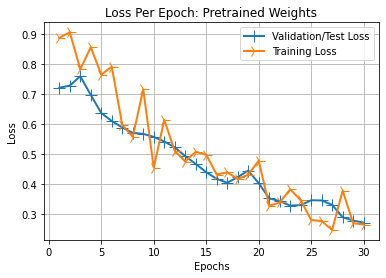

In [28]:
# Plotting loss of model with pretrained weights
fitted_dict = model_fitted.history
loss_values = fitted_dict['loss']
val_loss_values = fitted_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=12.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=12.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Loss Per Epoch: Pretrained Weights')
plt.grid(True)
plt.legend()
plt.show()

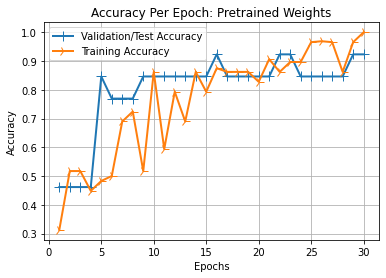

In [29]:
# plotting accuracy
fitted_dict = model_fitted.history
acc_values = fitted_dict['accuracy']
val_acc_values = fitted_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.title('Accuracy Per Epoch: Pretrained Weights')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
#for comparison purposes, this vgg has randomly initialized weights.
no_weight_model = VGG16(weights=None, include_top=False, input_tensor=Input(shape=input_shape))
head_random_model = no_weight_model.output
head_random_model = AveragePooling2D(pool_size=(4,4))(head_random_model)
head_random_model = Flatten()(head_random_model)
head_random_model = Dense(64, activation='elu')(head_random_model)
head_random_model = Dropout(0.5)(head_random_model)
head_random_model = Dense(2, activation='softmax')(head_random_model)

new_model = Model(inputs=no_weight_model.input, outputs=head_random_model)
for layer in no_weight_model.layers:
  layer.trainable = False

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta = 0.001)
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, 
                          patience = 5, 
                          verbose = 1,
                          restore_best_weights = True)
callbacks = [reduce_lr, earlystop]


n_epochs = 30
opt = Adam(lr=1e-3, decay= 1e-3/n_epochs)
new_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 8
new_model_fit = new_model.fit_generator(train_aug.flow(X_train, y_train, batch_size= batch_size),
                                   steps_per_epoch=len(X_train) // batch_size,
                                   validation_data=(X_test, y_test),
                                   validation_steps = len(X_test) // batch_size,
                                   callbacks = callbacks,
                                   epochs=n_epochs)



Epoch 1/30
4/4 [==============================] - 1s 129ms/step - loss: 0.6933 - accuracy: 0.5312 - val_loss: 0.6943 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 2/30
4/4 [==============================] - 0s 92ms/step - loss: 0.6947 - accuracy: 0.4138 - val_loss: 0.6936 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/30
4/4 [==============================] - 0s 80ms/step - loss: 0.6924 - accuracy: 0.4828 - val_loss: 0.6938 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 4/30
4/4 [==============================] - 0s 76ms/step - loss: 0.6900 - accuracy: 0.5517 - val_loss: 0.6940 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 5/30
4/4 [==============================] - 0s 73ms/step - loss: 0.6889 - accuracy: 0.5862 - val_loss: 0.6946 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 6/30
4/4 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5312
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4/4 [==============================] - 0s 82ms/step - loss: 0.6933

In [31]:
# predictions
pred = new_model.predict(X_test, batch_size=batch_size)
pred = np.argmax(pred, axis=1)

# new model evaluation
print(classification_report(y_test.argmax(axis=1), pred))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63         6
           1       0.00      0.00      0.00         7

    accuracy                           0.46        13
   macro avg       0.23      0.50      0.32        13
weighted avg       0.21      0.46      0.29        13



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


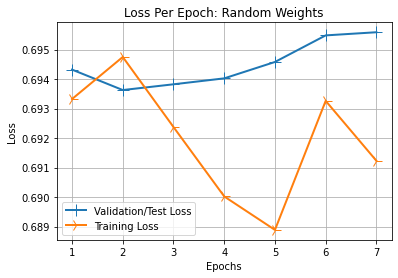

In [32]:
# Plotting loss of randomly intialized weights
fitted_dict_new = new_model_fit.history
loss_values = fitted_dict_new['loss']
val_loss_values = fitted_dict_new['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=12.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=12.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Loss Per Epoch: Random Weights')
plt.grid(True)
plt.legend()
plt.show()

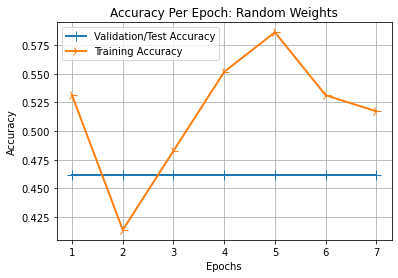

In [33]:
# plotting accuracy of randomly initialized weights 
fitted_dict_new = new_model_fit.history
acc_values = fitted_dict_new['accuracy']
val_acc_values = fitted_dict_new['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.title('Accuracy Per Epoch: Random Weights')
plt.grid(True)
plt.legend()
plt.show()